## DATA PREPARATION 

*  Of 1year of Ride Requests Data at OLA Bikes

* Time Window: 2020-03-26 to 2021-03-26

* Number of Good Ride Requests: 3708329

In [1]:
#!pip install ipywidgets

In [2]:
!pip install --upgrade ydata-profiling matplotlib


In [3]:
!pip install ydata-profiling


In [4]:
import pandas as pd
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
import gpxpy.geo
from datetime import datetime, timedelta
from joblib import dump, load
import pandas_profiling
import ydata_profiling

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/var/folders/8c/x24h_w8n7hb83_lmdv9v2zdm0000gn/T/ipykernel_2457/2955970535.py:9

In [5]:
df = pd.read_csv('../data/data_checkpoint/cleanedOLA_data.csv', compression = 'gzip')


In [6]:
len(df)

3708329

## Geospacial Feature Engineering - Clustering/Segmentation

* Here, we have divided whole India into regions using “K-Means Clustering”.

The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm.

In [7]:
coord = df[["pick_lat", "pick_lng"]].values
neighbors = []

In [8]:
coord

array([[12.975773, 77.57107 ],
       [12.930813, 77.60953 ],
       [12.960213, 77.58746 ],
       ...,
       [12.907576, 77.600685],
       [12.956665, 77.52187 ],
       [12.987954, 77.55588 ]])

In [9]:
def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = np.inf  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000, random_state = 5).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [10]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 0.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 9.0
Minimum distance between any two clusters = 82.39306872956554
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 18.0
Minimum distance between any two clusters = 0.7678687931376267
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 28.0
Minimum distance between any two clusters = 0.7486485342893064
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter

**Observation**

I want the minimum inter cluster distance between any two clusters to be less than 0.5mile and when number of clusters are 50 then this condition is being met  Therefore, I am  considering number of clusters to be 50.

In [11]:
coord = df[["pick_lat", "pick_lng"]].values
regions = MiniBatchKMeans(n_clusters = 50, batch_size = 10000, random_state = 0).fit(coord)
df["pickup_cluster"] = regions.predict(df[["pick_lat", "pick_lng"]])

In [12]:
df

,index,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,hour,mins,day,month,year,dayofweek,booking_timestamp,shift_booking_ts,booking_time_diff_hr,booking_time_diff_min,geodesic_distance,pickup_cluster
0,2374378,2020-10-10 07:34:16,-1.0,12.975773,77.571070,12.878468,77.445330,7,34,10,10,2020,5,1602315256,0,445087,26705254,17.38,15
1,2405894,2020-10-11 08:23:42,-1.0,12.930813,77.609530,12.960320,77.587210,8,23,11,10,2020,6,1602404622,1602315256,24,1489,4.06,28
2,2406076,2020-10-11 11:57:17,-1.0,12.960213,77.587460,12.930824,77.609610,11,57,11,10,2020,6,1602417437,1602404636,3,213,4.04,36
3,2500477,2020-10-16 17:51:07,-1.0,12.924353,77.549410,12.932216,77.581825,17,51,16,10,2020,4,1602870667,1602417451,125,7553,3.62,29
4,2694503,2020-10-30 09:00:44,-1.0,12.945731,77.622500,12.973030,77.616840,9,0,30,10,2020,4,1604048444,1602870685,327,19629,3.08,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708324,5768115,2021-02-12 19:37:11,99999.0,13.029848,77.593400,13.063751,77.589850,19,37,12,2,2021,4,1613158631,1613068718,24,1498,3.77,48
3708325,6102760,2021-02-19 20:43:25,99999.0,13.029296,77.592580,12.927923,77.627106,20,43,19,2,2021,4,1613767405,1613158631,169,10146,11.82,48
3708326,6137206,2021-02-20 17:34:45,99999.0,12.907576,77.600685,12.925874,77.607620,17,34,20,2,2021,5,1613842485,1613767405,20,1251,2.16,1
3708327,6555089,2021-02-27 08:26:23,99999.0,12.956665,77.521870,12.948099,77.562990,8,26,27,2,2021,5,1614414383,1613842485,158,9531,4.56,5


In [13]:
### Model to Define pickup cluster, given latitude and longitude
dump(regions,'../models/pickup_cluster_model.joblib' , compress = 3)


['../models/pickup_cluster_model.joblib']

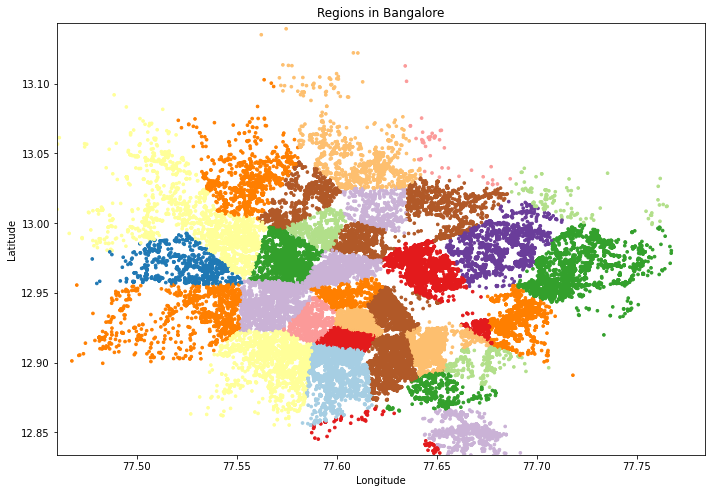

In [14]:
### These pickup clusters tell in which area most ride requests are coming. 
### Plotting Regions in Bangalore (our most rides requests here)
#### Bangalore:'boundingbox': ['12.8340125', '13.1436649', '77.4601025', '77.7840515']
bangalore_latitude_range = (12.8340125, 13.1436649)
bangalore_longitude_range = (77.4601025, 77.7840515)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = df.pick_lng.values[:100000], y = df.pick_lat.values[:100000], c = df.pickup_cluster.values[:100000], cmap = "Paired", s = 7)
ax.set_xlim(77.4601025, 77.7840515)
ax.set_ylim(12.8340125, 13.1436649)
ax.set_title("Regions in Bangalore")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

In [15]:
df.head()

,index,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,hour,mins,day,month,year,dayofweek,booking_timestamp,shift_booking_ts,booking_time_diff_hr,booking_time_diff_min,geodesic_distance,pickup_cluster
0,2374378,2020-10-10 07:34:16,-1.0,12.975773,77.57107,12.878468,77.445330,7,34,10,10,2020,5,1602315256,0,445087,26705254,17.38,15
1,2405894,2020-10-11 08:23:42,-1.0,12.930813,77.60953,12.960320,77.587210,8,23,11,10,2020,6,1602404622,1602315256,24,1489,4.06,28
2,2406076,2020-10-11 11:57:17,-1.0,12.960213,77.58746,12.930824,77.609610,11,57,11,10,2020,6,1602417437,1602404636,3,213,4.04,36
3,2500477,2020-10-16 17:51:07,-1.0,12.924353,77.54941,12.932216,77.581825,17,51,16,10,2020,4,1602870667,1602417451,125,7553,3.62,29
4,2694503,2020-10-30 09:00:44,-1.0,12.945731,77.62250,12.973030,77.616840,9,0,30,10,2020,4,1604048444,1602870685,327,19629,3.08,46


## Summing Ride Request Count to 30mins Interval groupby pickup cluster

In [16]:
def round_timestamp_30interval(x):
    if type(x)==str:
        x = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    return x- timedelta(minutes=x.minute%30, seconds=x.second, microseconds=x.microsecond)

df['ts'] = np.vectorize(round_timestamp_30interval)(df['ts'])

In [17]:

dataset = deepcopy(df)
dataset.ts = pd.to_datetime(dataset.ts)
dataset

,index,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,hour,mins,day,month,year,dayofweek,booking_timestamp,shift_booking_ts,booking_time_diff_hr,booking_time_diff_min,geodesic_distance,pickup_cluster
0,2374378,2020-10-10 07:30:00,-1.0,12.975773,77.571070,12.878468,77.445330,7,34,10,10,2020,5,1602315256,0,445087,26705254,17.38,15
1,2405894,2020-10-11 08:00:00,-1.0,12.930813,77.609530,12.960320,77.587210,8,23,11,10,2020,6,1602404622,1602315256,24,1489,4.06,28
2,2406076,2020-10-11 11:30:00,-1.0,12.960213,77.587460,12.930824,77.609610,11,57,11,10,2020,6,1602417437,1602404636,3,213,4.04,36
3,2500477,2020-10-16 17:30:00,-1.0,12.924353,77.549410,12.932216,77.581825,17,51,16,10,2020,4,1602870667,1602417451,125,7553,3.62,29
4,2694503,2020-10-30 09:00:00,-1.0,12.945731,77.622500,12.973030,77.616840,9,0,30,10,2020,4,1604048444,1602870685,327,19629,3.08,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708324,5768115,2021-02-12 19:30:00,99999.0,13.029848,77.593400,13.063751,77.589850,19,37,12,2,2021,4,1613158631,1613068718,24,1498,3.77,48
3708325,6102760,2021-02-19 20:30:00,99999.0,13.029296,77.592580,12.927923,77.627106,20,43,19,2,2021,4,1613767405,1613158631,169,10146,11.82,48
3708326,6137206,2021-02-20 17:30:00,99999.0,12.907576,77.600685,12.925874,77.607620,17,34,20,2,2021,5,1613842485,1613767405,20,1251,2.16,1
3708327,6555089,2021-02-27 08:00:00,99999.0,12.956665,77.521870,12.948099,77.562990,8,26,27,2,2021,5,1614414383,1613842485,158,9531,4.56,5


In [18]:
dataset = dataset[['ts','number','pickup_cluster']]

In [19]:
dataset=dataset.groupby(by = ['ts','pickup_cluster']).count().reset_index()
dataset.columns = ['ts','pickup_cluster','request_count']

In [20]:
dataset

,ts,pickup_cluster,request_count
0,2020-03-26 01:00:00,16,1
1,2020-03-26 01:00:00,28,3
2,2020-03-26 01:30:00,28,1
3,2020-03-26 01:30:00,41,2
4,2020-03-26 02:00:00,28,1
...,...,...,...
467913,2021-03-26 23:30:00,44,1
467914,2021-03-26 23:30:00,45,19
467915,2021-03-26 23:30:00,46,15
467916,2021-03-26 23:30:00,47,3


### There should be: 366days [2020-03-26 to 2021-03-26] * [(24*2) 30mins intervals] * 50 regions = 878400 data rows

In [21]:
## Adding Dummy pickup cluster -1

## Change this Data based on your data
l = [datetime(2020,3,26,00,00,00) + timedelta(minutes = 30*i) for i in range(0,48*365)]
lt = []
for x in l:
    lt.append([x, -1, 0])
temp = pd.DataFrame(lt, columns = ['ts','pickup_cluster','request_count'])
dataset = dataset.append(temp,ignore_index=True)

/var/folders/8c/x24h_w8n7hb83_lmdv9v2zdm0000gn/T/ipykernel_2457/693393654.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp,ignore_index=True)


In [22]:
data = dataset.set_index(['ts', 'pickup_cluster']).unstack().fillna(value=0).asfreq(freq='30Min').stack().sort_index(level=1).reset_index()

In [23]:
# Removing Dummy Cluster
data = data[data.pickup_cluster>=0]

In [24]:
assert len(data)==878400

## Adding TimeFeatures
*  hour, mins, dayofweek, quarter & month (to capture seasonality winter ride count, summer ride count, rainy weather ride count)
* During Rainy weather or extreme winter or extreme summer months, ride request will vary with weather

In [25]:
data['mins'] = data.ts.dt.minute
data['hour'] = data.ts.dt.hour
data['day'] = data.ts.dt.day
data['month'] = data.ts.dt.month
data['dayofweek'] = data.ts.dt.dayofweek
data['quarter'] = data.ts.dt.quarter

In [26]:
data

,ts,pickup_cluster,request_count,mins,hour,day,month,dayofweek,quarter
17568,2020-03-26 00:00:00,0,0.0,0,0,26,3,3,1
17569,2020-03-26 00:30:00,0,0.0,30,0,26,3,3,1
17570,2020-03-26 01:00:00,0,0.0,0,1,26,3,3,1
17571,2020-03-26 01:30:00,0,0.0,30,1,26,3,3,1
17572,2020-03-26 02:00:00,0,0.0,0,2,26,3,3,1
...,...,...,...,...,...,...,...,...,...
895963,2021-03-26 21:30:00,49,9.0,30,21,26,3,4,1
895964,2021-03-26 22:00:00,49,11.0,0,22,26,3,4,1
895965,2021-03-26 22:30:00,49,8.0,30,22,26,3,4,1
895966,2021-03-26 23:00:00,49,7.0,0,23,26,3,4,1


In [27]:
data.columns

Index(['ts', 'pickup_cluster', 'request_count', 'mins', 'hour', 'day', 'month',
       'dayofweek', 'quarter'],
      dtype='object')

In [28]:
data.to_csv('../data/data_checkpoint/preped_data.csv',index = False, compression = 'gzip')

In [29]:
#!pip install pandas-profiling


In [30]:
#import pandas_profiling

#profile = data.profile_report(title='Ride Request DataSet Analysis')
#profile.to_file(output_file="data_analysis_ride_request.html")

In [31]:
#profile